In [10]:
from matplotlib import pyplot as plt
from torchmetrics import Accuracy
import einops


In [49]:
from dataclasses import dataclass

@dataclass
class Config:
    in_features: int
    hidden_features: list[int]
    out_features: int
    num_epochs: int
    learning_rate: float
    num_layers: int
    std_init: float
    random_seed: int

RANDOM_SEED = 42

In [14]:
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Define the transformation to convert the image to a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset_idx, testset_idx = train_test_split(
    range(len(full_trainset)),
    test_size=0.2,
    stratify=full_trainset.targets,
    random_state=RANDOM_SEED
)
trainset = Subset(full_trainset, trainset_idx)
testset = Subset(full_trainset, testset_idx)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
valloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=4)

In [8]:
images_batch, labels_batch = next(iter(trainloader))

print(images_batch.shape)
print(labels_batch.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


(<matplotlib.image.AxesImage at 0x16ba89820>, 5)

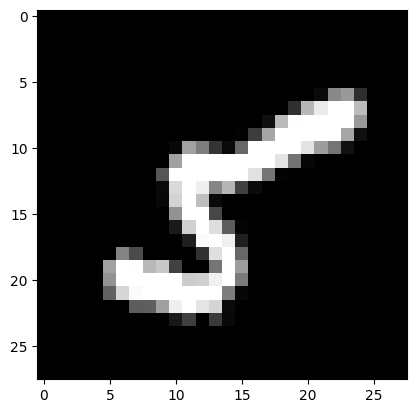

In [9]:
plt.imshow(images_batch[0].squeeze().numpy(), cmap='gray'), int(labels_batch[0].squeeze())


In [50]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, std_init: float, random_seed: int):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_features, out_features))
        nn.init.normal_(self.W, std=std_init, generator=torch.Generator().manual_seed(random_seed))
        self.b = nn.Parameter(torch.zeros(out_features))
    
    def forward(self, x):
        return einops.einsum(
            x, self.W, "batch in_features, in_features out_features -> batch out_features"
        ) + self.b    

In [87]:
class MyNN(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.input_layer = Linear(config.in_features, config.hidden_features[0], config.std_init, config.random_seed)
        self.hidden_layers = [Linear(config.hidden_features[i], config.hidden_features[i+1], config.std_init, config.random_seed) for i in range(config.num_layers - 1)]
        self.output_layer = Linear(config.hidden_features[-1], config.out_features, config.std_init, config.random_seed)
        print(self.input_layer.W.shape)
        print([l.W.shape for l in self.hidden_layers])
        print(self.output_layer.W.shape)
    
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        return self.output_layer(x)

In [88]:
config = Config(
    in_features=28*28,
    hidden_features=[128, 64],
    out_features=10,
    num_epochs=10,
    learning_rate=3e-2,
    num_layers=2,
    std_init=0.02,
    random_seed=RANDOM_SEED
)
my_nn = MyNN(config)
print(my_nn)

torch.Size([784, 128])
[torch.Size([128, 64])]
torch.Size([64, 10])
MyNN(
  (input_layer): Linear()
  (output_layer): Linear()
)


In [89]:
accuracy = Accuracy(task="multiclass", num_classes=10)
optimizer = torch.optim.SGD(my_nn.parameters(), lr=config.learning_rate, momentum=0.9)

my_nn.train()
losses = []

for epoch in range(config.num_epochs):
    for batch in trainloader:
        x, y = batch
        x = einops.rearrange(x, "batch channel h w -> batch channel (h w)").squeeze()
        y_hat = my_nn(x)
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        accuracy.update(y_hat, y)
    print(f"Epoch {epoch+1}/{config.num_epochs}, Loss: {loss.item()}, accuracy: {accuracy.compute()}")

print("Training complete")



Epoch 1/10, Loss: 0.2585015594959259, accuracy: 0.7075416445732117
Epoch 2/10, Loss: 0.2162526398897171, accuracy: 0.8105833530426025
Epoch 3/10, Loss: 0.21116669476032257, accuracy: 0.8506041765213013
Epoch 4/10, Loss: 0.14298628270626068, accuracy: 0.8734583258628845
Epoch 5/10, Loss: 0.11517266184091568, accuracy: 0.888629138469696
Epoch 6/10, Loss: 0.021273892372846603, accuracy: 0.8997326493263245
Epoch 7/10, Loss: 0.11401424556970596, accuracy: 0.9083541631698608
Epoch 8/10, Loss: 0.07526193559169769, accuracy: 0.9152916669845581
Epoch 9/10, Loss: 0.05886608734726906, accuracy: 0.9210602045059204
Epoch 10/10, Loss: 0.0874098688364029, accuracy: 0.925891637802124
Training complete


tensor(0.9259)


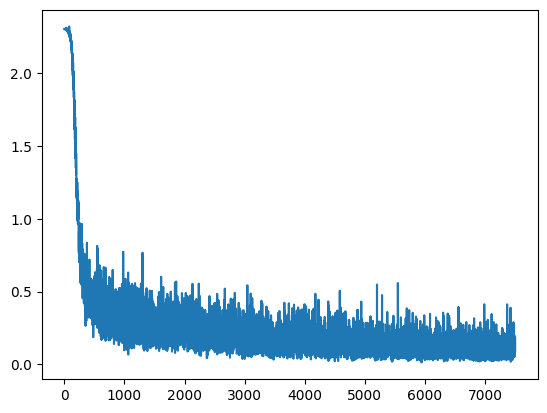

In [90]:
print(accuracy.compute())
plt.plot(losses)
plt.show()

tensor(0.9611)


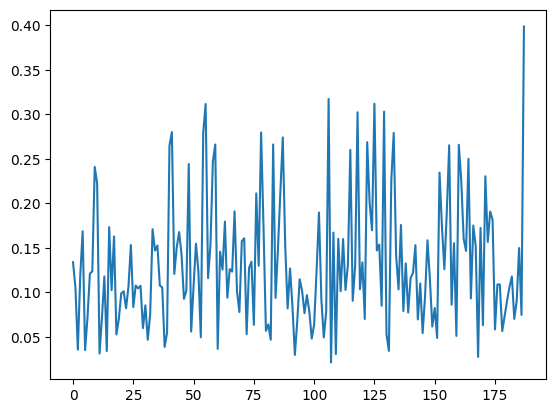

In [91]:
val_losses = []
my_nn.eval()
accuracy.reset()
with torch.no_grad():
    for batch in valloader:
        x, y = batch
        x = einops.rearrange(x, "batch channel h w -> batch channel (h w)").squeeze()
        y_hat = my_nn(x)
        loss = F.cross_entropy(y_hat, y)
        val_losses.append(loss.item())
        accuracy.update(y_hat, y)

print(accuracy.compute())
plt.plot(val_losses)
plt.show()